# Modeling: Classifying metastasis

In [232]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

# import specific modules for ML 
from sklearn.model_selection import train_test_split,GridSearchCV 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

In [233]:
df = pd.read_csv("../data/cleaned/NCDB_cleaned_N1348.csv")


### Preprocessing the data 

- separate features and outcome 
- one-hot encode the categorical variables
- down-sample the majority class ??


In [234]:
# define outcome and features 
outcome = df['metastasis']
# remove outcome and the variables used to generate the outcome.
features = df.drop(columns =['metastasis',
                             'regional_nodes_positive_bin',
                             'regional_nodes_ITC_bin',
                             'lymph_node_mets_bin', ])

In [235]:
# one-hot encode categorical variables  
one_hot_tumor_site = pd.get_dummies(features['tumor_site'], prefix =  "tumor_site")
# Drop the category versions, as it is now encoded
features2 = features.drop(columns = ['tumor_site'])
# Join the encoded df to the other features
features3 = features2.join(one_hot_tumor_site)

features3.head()

,AGE,SEX,tumor_size_bins_cm,immuno_suppressed,tumor_lymphocytes,lymph_vasc_invasion,tumor_depth,tumor_site_extremity,tumor_site_head_neck,tumor_site_other,tumor_site_trunk
0,58,1,1.0,0,0,0.0,3.8,1,0,0,0
1,63,1,1.0,0,0,0.0,1.0,1,0,0,0
2,76,1,1.0,0,1,0.0,9.4,0,1,0,0
3,65,1,1.0,0,0,1.0,0.8,1,0,0,0
4,67,2,1.0,0,1,0.0,8.5,0,0,1,0


### Split data for train-test evaluation
- split the data into train and test sets
- split the training data into CV folds
-- only 2 folds, because small N 
-- with stratification for outcome class
-- with random re-sampling to get more confidence 

In [236]:
# split into train-test split
X_trainval, X_test, y_trainval, y_test = train_test_split(features3, outcome,
                                                   random_state = 0)
print("Training data N: {}".format(X_trainval.shape))
print("Test data N: {}".format(X_test.shape))
print("Metastasis cases in test set: \n {}".format(y_test.value_counts()))

Training data N: (384, 11)
Test data N: (129, 11)
Metastasis cases in test set: 
 0    97
1    32
Name: metastasis, dtype: int64


In [237]:
# use repeated stratified k-fold so that we get resampled (randomized) repeats on small sample!
# only splitting twice so that the validation sets for each CV are not too small! 
# automatically stratfies splits based on outcome variable.
CV_folds =  RepeatedStratifiedKFold(n_splits = 2, n_repeats =  5,  random_state = 0)
CV_folds

#for train, test in CV_folds.split(X_trainval):
   # print("%s %s" % (train, test))
 #   print("stuff")

RepeatedStratifiedKFold(n_repeats=5, n_splits=2, random_state=0)

### Model selection
**Logistic Regression** to classify metastasis from the available features. 
- grid search to allow the regularization strength (c) to vary
- find the best model predictions based on AUC and accuracy

In [238]:
# larger C = less regularization
param_grid = {'C': [0.01, 0.1, 1, 10]}
# scores to evaluate model performance
scores = {'AUC': 'roc_auc'} #, 'Accuracy': make_scorer(accuracy_score)}
lr_grid = GridSearchCV(LogisticRegression(),
                    param_grid = param_grid, 
                    cv = CV_folds, 
                   # scoring = scores,
                    n_jobs =  -1)

lr_grid.fit(X_train, y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=2, random_state=0),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10]})

In [239]:
print("Best CV Accuracy score: %0.5f)" % lr_grid.best_score_)
print(lr_grid.best_params_)

#lr_grid.cv_results_

Best CV Accuracy score: 0.73281)
{'C': 0.01}


### Evaluate the best model on the test data
- fit the final model, with all of the training data
- run on hold-out test data.
- check the classification scores of each class 
- examine ROC curve


In [240]:
lr_model = LogisticRegression(C = 0.01)
# fit the model on all  of the training data 
lr_model.fit(X_trainval, y_trainval)
print("Accuracy score on test set: %.5f" % lr_model.score(X_test, y_test))

Accuracy score on test set: 0.76744


In [316]:
# get our predictions on the test dataset for conversion = 1 or 0
y_pred = lr_model.predict(X_test)

## confusion matrix, which is  based on splitting at 50% chance.
from sklearn.metrics import confusion_matrix 
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))#[1][0]
cm = cm.rename(columns = {0:'Predicted_negative', 1:'Predicted_positive'}, 
         index = {0:'True_negative', 1:'True_positive'})


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [242]:
print ('True negative cases - predicted negative:', cm.Predicted_negative[0])
print ('True positive cases - predicted positive:', cm.Predicted_positive[1])
print ('True positive cases - predicted negative (False negatives):', cm.Predicted_negative['True_positive'])
print ('True negative cases - predicted positive (False positives):',  cm.Predicted_positive['True_negative'])

True negative cases - predicted negative: 97
True positive cases - predicted positive: 2
True positive cases - predicted negative (False negatives): 30
True negative cases - predicted positive (False positives): 0


In [243]:
print(classification_report(y_test, 
          y_pred, target_names = ["no metastasis (0)", "metastasis (1)"]))

                   precision    recall  f1-score   support

no metastasis (0)       0.76      1.00      0.87        97
   metastasis (1)       1.00      0.06      0.12        32

         accuracy                           0.77       129
        macro avg       0.88      0.53      0.49       129
     weighted avg       0.82      0.77      0.68       129



### Summary of results
**For positive cases of metastasis:**

- Precision is perfect, because no false positives to predict metastasis.
- But recall  is very poor,  because many false negatives (positive cases going undetected, bad!!)
-- We need better recall.

**For negative cases:**
- Precision is 76%, because about 1/3 of positive cases are incorrectly classified as negative cases.
- Recall is perfect, because no negative cases were incorrectly classified as positive.

### what if we change threshold for classification?
- ideally want to know  if we can detect a patient with <5 % chance of metastasis 
- we can change the threshold of  the predictions! 
-- more towards positive class, especially if we care about high recall 
--  and care less about false positives.
--  to do this, we can lower the threshold that gets counted as a positive class

In [315]:

towards_positive_pred = lr_model.predict_proba(X_test)[:,1] > 0.20
cm = pd.DataFrame(confusion_matrix(y_test, towards_positive_pred))
cm = cm.rename(columns = {0:'Predicted_negative', 1:'Predicted_positive'}, 
         index = {0:'True_negative', 1:'True_positive'})
cm

,Predicted_negative,Predicted_positive
True_negative,0,97
True_positive,0,32


if we change threshold to 0.05, we don't have any 'true negative' patients that are predicted to be negative

becasue everyone's predicted probability of a positive case is > 0.05!! 

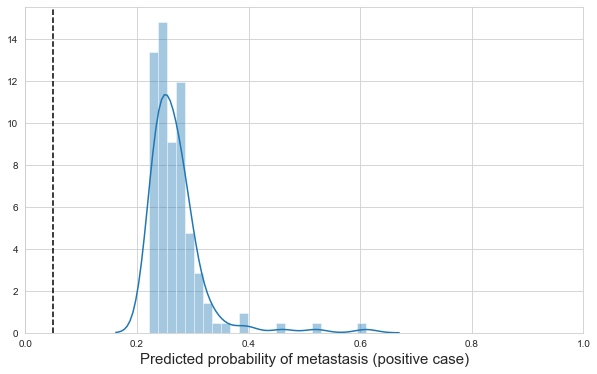

In [307]:
y_pred_prob =pd.DataFrame(lr_model.predict_proba(X_test))
y_pred_prob = y_pred_prob.rename(columns = {0: 'Pred Prob of Negative Case', 1: 'Pred Prob of Positive Case'})
plt.figure(figsize =  (10,6))
g= sns.distplot(y_pred_prob["Pred Prob of Positive Case"])
plt.xticks(np.arange(0.0, 1.1, step=0.2))
plt.axvline(x = 0.05, ymin = 0, ymax  =1, linestyle = "--", color = "black")
g.set_xlabel("Predicted probability of metastasis (positive case)", size = 15)
plt.savefig('../figures/pred_prob_positive.pdf', bbox_inches = 'tight')


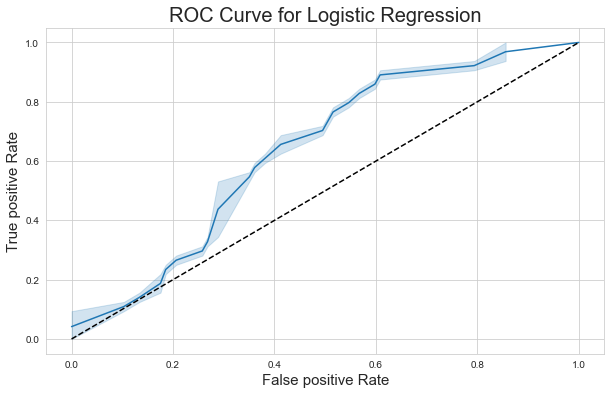

In [305]:
# get the data needed to make ROC curve 
# Looking at the likelihood to predict NEGATIVE CASE.
# Threshold is 5% 
fpr, tpr, thresholds = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
fpr = pd.DataFrame(fpr)
tpr = pd.DataFrame(tpr)
thres = pd.DataFrame(thresholds)
roc_df = pd.concat([fpr, tpr, thres], axis=1)
roc_df.columns = ['false positive rate','true positive rate', 'threshold']

plt.figure(figsize =  (10,6))
g = sns.lineplot(data = roc_df,   x = "false positive rate", y = "true positive rate")
plt.plot([0,1], [0,1], color = "black", linestyle='--')
g.set_title("ROC Curve for Logistic Regression",  size =  20)
g.set_ylabel("True positive Rate", size = 15)
g.set_xlabel("False positive Rate", size = 15)
plt.savefig('../figures/LR_ROC_curve.pdf', bbox_inches = 'tight')

### Precision-recall curve
another way of looking at it

In [293]:
from sklearn.metrics import precision_recall_curve
# get precision and recall for positive class
precision, recall, thresholds = precision_recall_curve(y_test, lr_model.predict_proba(X_test)[:,1])
precision = pd.DataFrame(precision)
recall = pd.DataFrame(recall)
thresholds = pd.DataFrame(thresholds)
pr_df = pd.concat([precision, recall, thresholds], axis=1)
pr_df.columns = ['precision','recall', 'thresholds']
pr_df['set_thres'] = pr_df.thresholds.round(2) == 0.5
pr_df

,precision,recall,thresholds,set_thres
0,0.278261,1.00000,0.230165,False
1,0.271930,0.96875,0.230441,False
2,0.265487,0.93750,0.231290,False
3,0.267857,0.93750,0.231498,False
4,0.270270,0.93750,0.232658,False
...,...,...,...,...
111,0.750000,0.09375,0.399342,False
112,1.000000,0.09375,0.460618,False
113,1.000000,0.06250,0.520432,False
114,1.000000,0.03125,0.610427,False


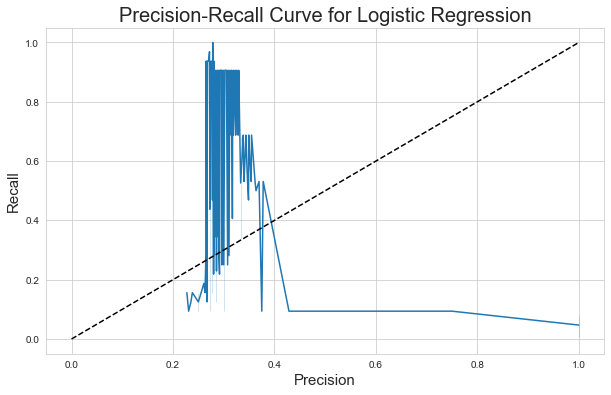

In [294]:

# plot 
plt.figure(figsize =  (10,6))
g = sns.lineplot(data = pr_df,   x = "precision", y = "recall")
plt.plot([0,1], [0,1], color = "black", linestyle='--')
g.set_title("Precision-Recall Curve for Logistic Regression",  size =  20)
g.set_xlabel("Precision", size = 15)
g.set_ylabel("Recall", size = 15)
plt.savefig('../figures/LR_Precision_recall_curve.pdf', bbox_inches = 'tight')

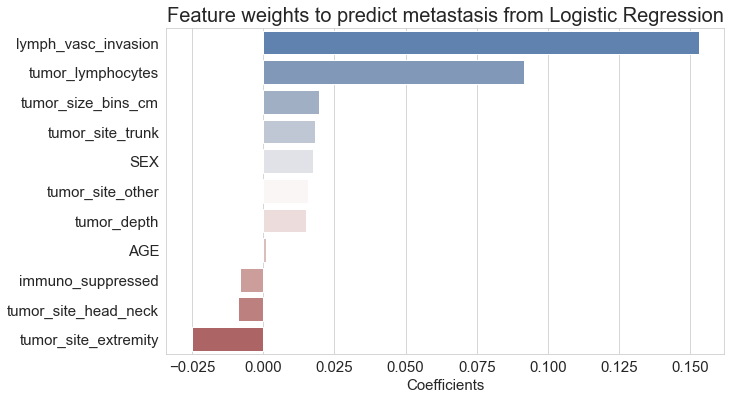

In [253]:
# get coefficients out into a dataframe
coefs = pd.DataFrame(lr_model.coef_.T)
features = pd.DataFrame(X_test.columns)
coefs_df = pd.concat([features, coefs], axis=1)
coefs_df.columns = ['features', 'coefs']
# sort the coefficients by value 
coefs_df = coefs_df.sort_values(by = 'coefs', 
                           ascending= False, ignore_index=True)

n_features =  coefs_df.shape[0]
plt.figure(figsize =  (10,6))
g = sns.barplot(data = coefs_df, y = 'features', x = "coefs",
            palette = sns.color_palette("vlag", n_features))
g.set_ylabel("")
g.tick_params(labelsize = 15)
g.set_xlabel("Coefficients", size = 15)
g.set_title("Feature weights to predict metastasis from Logistic Regression", size = 20);
plt.savefig('../figures/LR_feature_weights.pdf', bbox_inches = 'tight')

# small sample problem
1) drop certain features to increase  sample size (there may be other features to include instead)

2) stratify CV so that classes are balanced - done

3) random sampling within CV so that we have 25 runs - done

4) upsample the minority class?? do not want to downsample majority class.


# How to optimize model selection  for predicting  NEGATIVE class

1) use negative  class's recall as our metric to compare 

2) change threshold to 5% likelihood?

3) get confidence intervals around predictions